In [1]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [5]:
pd.read_feather('../data/train_dataset.fth').groupby('target').size()

target
0.0    328
1.0    697
dtype: int64

In [64]:
data = pd.read_feather('../data/train.small_sample.fth')
data['session_end'] = data['action_dt'].apply(lambda l: max(l))
data.head(2)

,user_id,session_id,vacancy_id,action_type,action_dt,session_end
393,u_341718,s_3846493,"[v_911837, v_1884096, v_1715539, v_1245745, v_...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, ...","[2023-11-04T10:19:39.242000000, 2023-11-04T10:...",2023-11-04 10:31:47.073
413,u_224429,s_30564375,"[v_2560758, v_1654519, v_2551855, v_2373031, v...","[2, 2, 2, 2, 2, 2, 2, 2, 2]","[2023-11-04T15:15:25.763000000, 2023-11-04T15:...",2023-11-04 15:34:41.822


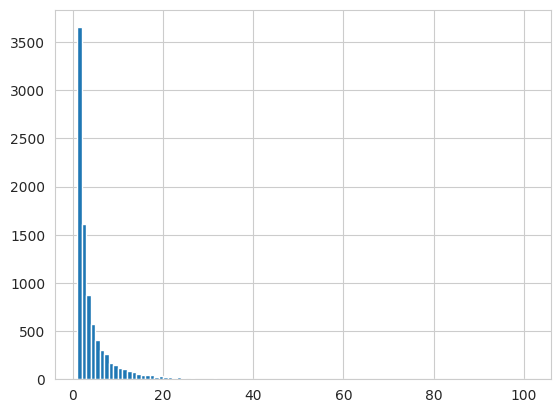

In [65]:
plt.hist(data.groupby('user_id').size(), range=(1, 101), bins=100)
plt.show()

In [66]:
n_session = data.groupby('user_id').size().reset_index().rename(columns={0: 'n_session'})

big_users = data.merge(n_session[(n_session['n_session'] > 1)][['user_id']], on='user_id')
big_users = big_users.sort_values('session_end').groupby('user_id').tail(5)

data.shape, big_users.shape

((33804, 6), (18733, 6))

In [67]:
import collections

class Candidate:
    def __init__(self, vac):
        self.vac = vac
        self.sessions_back_first = 1000
        self.sessions_back_last = 1000
        self.action_1 = 0
        self.action_2 = 0
        self.action_3 = 0

    def pass_session(self):
        self.sessions_back_last += 1
        self.sessions_back_first += 1

    def __repr__(self):
        return f'Candidate {self.vac}:\t{self.action_1}\t{self.action_2}\t{self.action_3}' \
            f'\t{self.sessions_back_first}\t{self.sessions_back_last}'

    def get_features(self):
        return {
            'vac': self.vac,
            'action_1': self.action_1,
            'action_2': self.action_2,
            'action_3': self.action_3,
            'sessions_back_first': self.sessions_back_first,
            'sessions_back_last': self.sessions_back_last,
        }

def candidates_to_df(d):
    return pd.DataFrame([e.get_features() for _, e in d.items()])

dataset = None

for user_id, user_sessions in tqdm.tqdm(big_users.groupby('user_id')):
    candidates = dict()
    for _, row in user_sessions.sort_values('session_end').iterrows():
        order = np.argsort(row['action_dt'])
        actions = row['action_type'][order]
        vacs = row['vacancy_id'][order]
        session = pd.DataFrame({
            'action': actions,
            'vac': vacs,
        })
    
        applies = session[session['action'] == 1][['vac']]
        applies['target'] = 1
    
        if len(candidates) > 0:
            candidates_df = candidates_to_df(candidates)
            candidates_df = candidates_df.merge(applies, how='left', on='vac')
            candidates_df['target'] = candidates_df['target'].fillna(0)
            candidates_df = pd.concat([
                candidates_df[candidates_df['target'] == 1],
                candidates_df[candidates_df['target'] == 0].sample(frac=0.01),
            ])
            candidates_df['user_id'] = user_id
            candidates_df['session_id'] = row['session_id']
        
            if dataset is None:
                dataset = candidates_df
            else:
                dataset = pd.concat([dataset, candidates_df], ignore_index=True)
    
        # add new candidates
        for _, action in session.iterrows():
            if action['vac'] not in candidates:
                candidates[action['vac']] = Candidate(action['vac'])
                candidates[action['vac']].sessions_back_first = 0
            candidates[action['vac']].sessions_back_last = 0
    
            if action['action'] == 1:
                candidates[action['vac']].action_1 += 1
            elif action['action'] == 2: 
                candidates[action['vac']].action_2 += 1
            elif action['action'] == 3: 
                candidates[action['vac']].action_3 += 1
    
        # update candidates
        for vac in candidates:
            candidates[vac].pass_session()


100%|████████████████████████████████████████████████████████████████████████████████████████| 5180/5180 [01:13<00:00, 70.80it/s]


In [68]:
dataset.head(3)

,vac,action_1,action_2,action_3,sessions_back_first,sessions_back_last,target,user_id,session_id
0,v_1739178,1,1,0,2,2,0.0,u_1000023,s_19388302
1,v_1045219,0,1,0,1,1,0.0,u_1000609,s_4215418
2,v_1952209,0,3,0,4,1,0.0,u_1002423,s_18808667


In [70]:
dataset.groupby('target').size()

target
0.0    328
1.0    697
dtype: int64